
# Week 3 - Clustering & Topic Modeling

This week, we take a text corpus that we have developed, and we first break it into discrete document chunks through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of content clustering called topic modeling. This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. Finally, we will consider how to construct models that take document cluster and topic loading as predictive features.

For this notebook we will be using the following packages:

In [79]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [80]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [81]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [82]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,"""auto\nfrom"
4,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\n\nThe previous article referred to the fac...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [83]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [84]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [85]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

We can also lookup the indices of different words using the Vectorizer

In [86]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [87]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [88]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.046688020755456),
 ('certain', 0.1589865268627092),
 ('apple', 0.22685454684169398),
 ('13', 0.1411362504801527),
 ('rgb', 0.1817286448065436),
 ('monitors', 0.1619412292430009),
 ('there', 0.0749569030656185),
 ('has', 0.07484299310086841),
 ('been', 0.095991006908172),
 ('problem', 0.18819404816424326),
 ('with', 0.05464092321093494),
 ('the', 0.1109950967372947),
 ('high', 0.12601141569529475),
 ('voltage', 0.19706119834212132),
 ('capasitor', 0.242206441914102),
 ('knows', 0.16299450361806797),
 ('about', 0.15540750198460515),
 ('this', 0.05749878121929968),
 ('and', 0.04330392033255178),
 ('is', 0.04793741654764163)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [89]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [90]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
5       What is the value of an SE (HDFD) 4/20?\n\n-David
6       \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7       \n\n\n    Nope. The Apple 16" monitor does not...
8       \n\nIs it a hidden option?  I'm using PowerStr...
9       \n\n\nThe previous article referred to the fac...
10      \n\n\n    Yes. That is exactly what it means. ...
11      I saw once an article about a new line of Macs...
12      So, will it be possible to have a NuBus or PDS...
13      \n\n\nWho knows... I just quoted what was "wri...
14      \n\nI also returned PB memory last summer for ...
15      \n\nI think all Powerbooks use the same 2 Meg ...
16      A question in general about displaying NTSC th...
17      The li

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [91]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [92]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [93]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [94]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [95]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_cur

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [96]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,category,source_file,text,kmeans_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",0
1,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,Does anyone know how to reach Micron? I am in...,0
2,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,Hi there!\n\nCould some kind soul tell me what...,0
3,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,"""auto\nfrom",0
4,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\n Don't believe the hype. There is no su...,0
5,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,0
6,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,0
7,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",0
8,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,0
9,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\n\nThe previous article referred to the fac...,0


We can also look at the distinguishing features in each cluster:

In [97]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 mac
 thanks
 just
 does
 drive
 apple
 don
 like
 new


Cluster 1:
 window
 server
 use
 motif
 using
 widget
 program
 application
 like
 code


Cluster 2:
 sale
 00
 offer
 shipping
 condition
 asking
 new
 sell
 interested
 price


Cluster 3:
 car
 cars
 engine
 like
 just
 good
 think
 don
 oil
 dealer




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [98]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [99]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [100]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

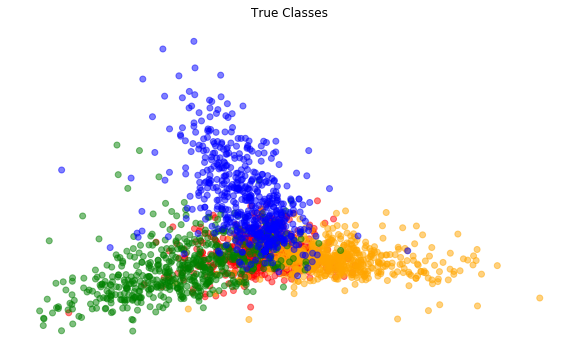

In [101]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

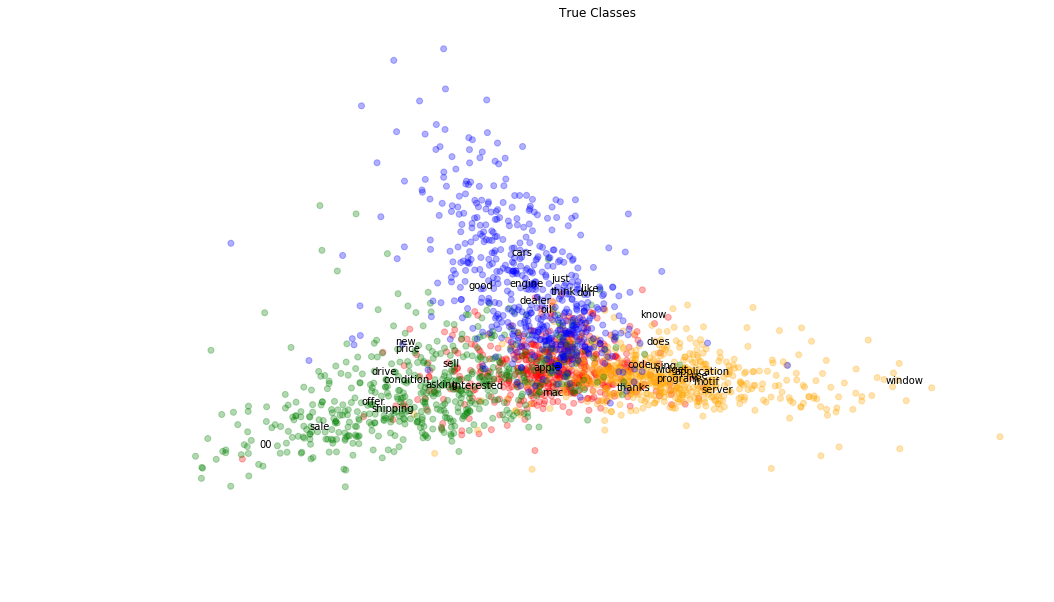

In [102]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [103]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

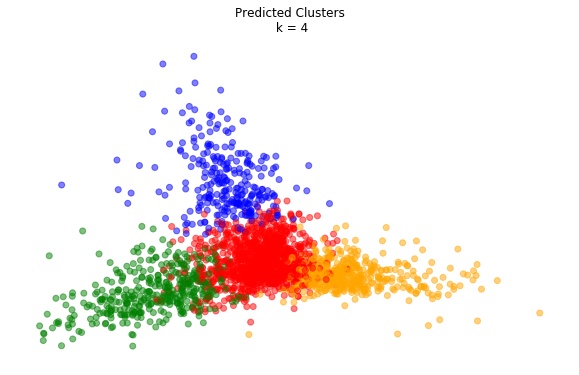

In [104]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [105]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [106]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters

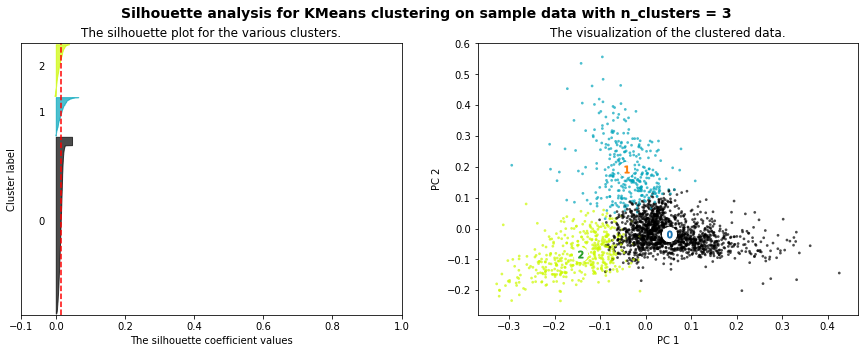

For n_clusters = 3, The average silhouette_score is : 0.014


In [107]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

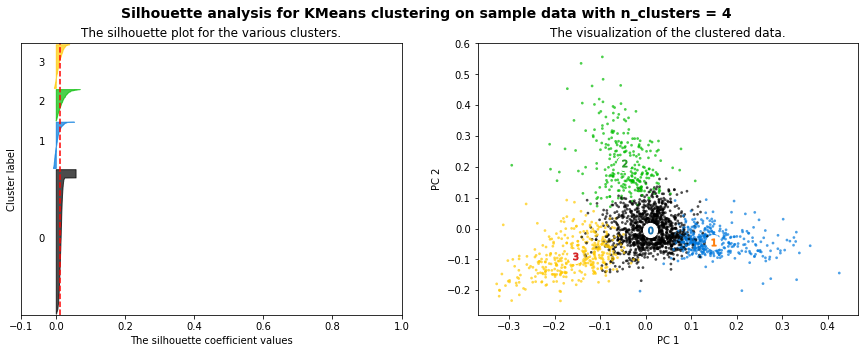

For n_clusters = 4, The average silhouette_score is : 0.012


In [108]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

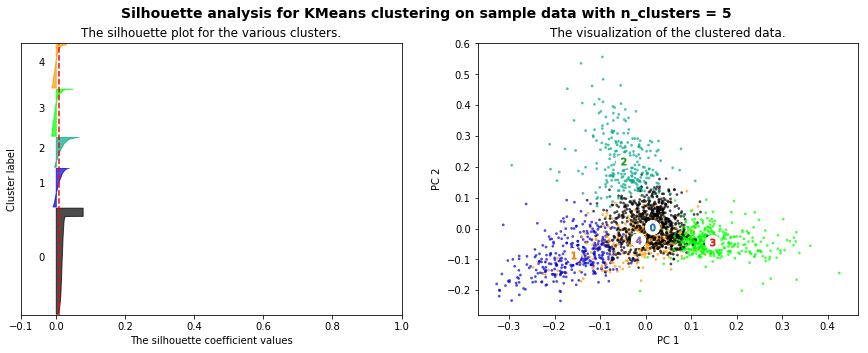

For n_clusters = 5, The average silhouette_score is : 0.010


In [109]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

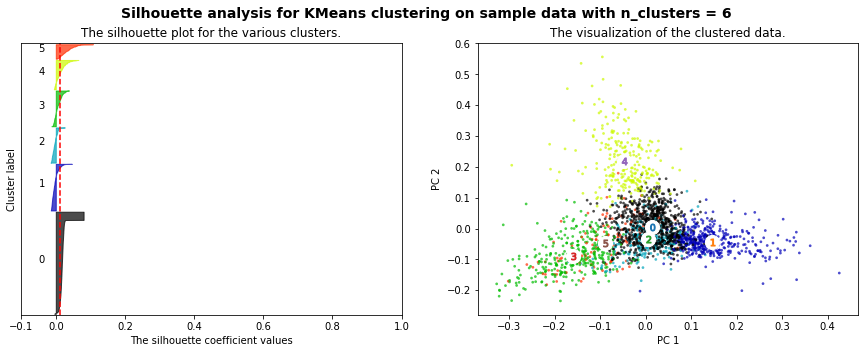

For n_clusters = 6, The average silhouette_score is : 0.011


In [110]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [111]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [112]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [113]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [114]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [115]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [116]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

And visualize:

In [117]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

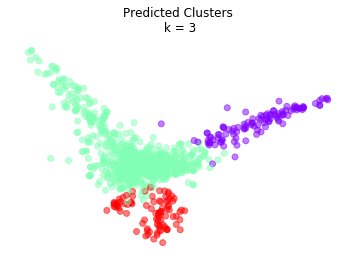

In [118]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters; with Silhouette analysis or maybe some of the metric although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [119]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
5,5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy13.txt,raw/Kennedy/01Aug2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
6,6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy14.txt,raw/Kennedy/01Aug2006Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
7,7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy5.txt,raw/Kennedy/01Aug2007Kennedy5.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,1
8,8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy6.txt,raw/Kennedy/01Aug2007Kennedy6.txt,FOR IMMEDIATE RELEASE Rachel Racus...,Kennedy,1
9,9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy7.txt,raw/Kennedy/01Aug2007Kennedy7.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,1


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

The analysis below indicates there may be several categories that annual letters to shareholders commonly use: Note 'footprint' and 'education' fall into similar clusters. Also, 'mergers' 'competition'' and 'repurchases' fall into similar categories. However, silhouette analysis indicates the clusters are rather all-encompassing, with the more categories the better. I need either a larger data set or to better refine my sample.

#  Load data

In [80]:
df = pandas.read_pickle('C:\\Users\\Andrew\\content-analysis-2018\\3-Clustering-and-Topic-Modeling\\pandasDF.pkl')

In [81]:
df.head(5)

,company,text,year
0,3M Letter,dear shareholder:\n\nthanks to the hard work o...,2000
1,Alcoa Letter,luluâ\nmumÂ» nl am.â\n\n \n\n \n\n1â0 ai...,2000
2,American Express Letter,"cardmembers, a reflection of our successful ef...",2000
3,AT&T Letter,the transformation of at&t\n\nthree years ago ...,2000
4,Boeing Letter,here is our plan for growing the boeing compan...,2000


#  3 Cluster, K-means with plotting

In [82]:
targetDF = df
textColumn = 'text'
numCategories = 3

In [83]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

In [84]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [85]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

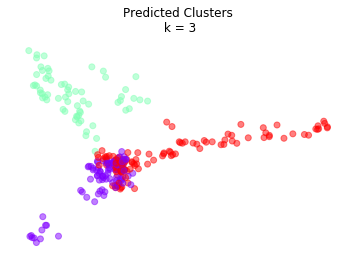

In [86]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In [87]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 include
 stay
 impact
 job
 dië
 different
 institutional
 direct
 allowed
 partnerships


Cluster 1:
 ce
 ceo
 education
 institutional
 impact
 footprint
 stock
 current
 direct
 include


Cluster 2:
 values
 reserves
 things
 lower
 unprecedented
 tions
 personal
 allows
 institutional
 cloud




In [88]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,company,text,year,kmeans_predictions
0,3M Letter,dear shareholder:\n\nthanks to the hard work o...,2000,0
1,Alcoa Letter,luluâ\nmumÂ» nl am.â\n\n \n\n \n\n1â0 ai...,2000,0
2,American Express Letter,"cardmembers, a reflection of our successful ef...",2000,2
3,AT&T Letter,the transformation of at&t\n\nthree years ago ...,2000,1
4,Boeing Letter,here is our plan for growing the boeing compan...,2000,2
5,Caterpillar Letter,âplan. are in place to acmieve $30 illllon\n...,2000,2
6,Citigroup Letter,citigroup is\n\n230\n\n> > > > > > > > > dear ...,2000,2
7,Coca Cola Letter,"dear fellow share own ers,\n\nthe coca-cola co...",2000,0
8,Disney 2000 Le,i) e mxtl\n:: [h [u\n\n \n\nt0 felluh dissey ...,2000,0
9,DuPont Letter,"dupont in 2000 had a strong year, but by no me...",2000,2


# 4 cluster, K-means

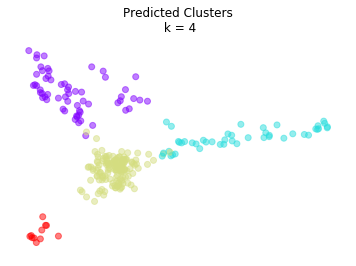

Top terms per cluster:
Cluster 0:
 include
 stay
 impact
 job
 dië
 different
 institutional
 direct
 allowed
 partnerships


Cluster 1:
 ce
 ceo
 education
 institutional
 impact
 footprint
 stock
 current
 direct
 include


Cluster 2:
 values
 reserves
 things
 lower
 unprecedented
 tions
 personal
 allows
 institutional
 cloud


Cluster 3:
 reducing
 00
 merger
 returns
 competition
 marketing
 authority
 repurchases
 highest
 page




,company,text,year,kmeans_predictions
0,3M Letter,dear shareholder:\n\nthanks to the hard work o...,2000,2
1,Alcoa Letter,luluâ\nmumÂ» nl am.â\n\n \n\n \n\n1â0 ai...,2000,2
2,American Express Letter,"cardmembers, a reflection of our successful ef...",2000,1
3,AT&T Letter,the transformation of at&t\n\nthree years ago ...,2000,0
4,Boeing Letter,here is our plan for growing the boeing compan...,2000,2
5,Caterpillar Letter,âplan. are in place to acmieve $30 illllon\n...,2000,2
6,Citigroup Letter,citigroup is\n\n230\n\n> > > > > > > > > dear ...,2000,1
7,Coca Cola Letter,"dear fellow share own ers,\n\nthe coca-cola co...",2000,2
8,Disney 2000 Le,i) e mxtl\n:: [h [u\n\n \n\nt0 felluh dissey ...,2000,2
9,DuPont Letter,"dupont in 2000 had a strong year, but by no me...",2000,2


In [89]:
targetDF = df
textColumn = 'text'
numCategories = 4
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

# 2 Cluster, K-means

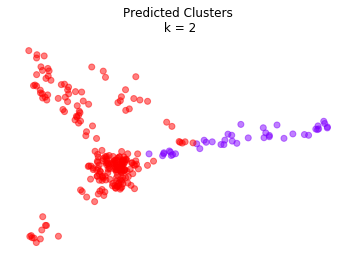

Top terms per cluster:
Cluster 0:
 include
 stay
 impact
 job
 dië
 different
 institutional
 direct
 allowed
 partnerships


Cluster 1:
 ce
 ceo
 education
 institutional
 impact
 footprint
 stock
 current
 direct
 include




,company,text,year,kmeans_predictions
0,3M Letter,dear shareholder:\n\nthanks to the hard work o...,2000,1
1,Alcoa Letter,luluâ\nmumÂ» nl am.â\n\n \n\n \n\n1â0 ai...,2000,1
2,American Express Letter,"cardmembers, a reflection of our successful ef...",2000,0
3,AT&T Letter,the transformation of at&t\n\nthree years ago ...,2000,1
4,Boeing Letter,here is our plan for growing the boeing compan...,2000,1
5,Caterpillar Letter,âplan. are in place to acmieve $30 illllon\n...,2000,1
6,Citigroup Letter,citigroup is\n\n230\n\n> > > > > > > > > dear ...,2000,0
7,Coca Cola Letter,"dear fellow share own ers,\n\nthe coca-cola co...",2000,1
8,Disney 2000 Le,i) e mxtl\n:: [h [u\n\n \n\nt0 felluh dissey ...,2000,1
9,DuPont Letter,"dupont in 2000 had a strong year, but by no me...",2000,1


In [90]:
targetDF = df
textColumn = 'text'
numCategories = 2
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

# Silhouette Analysis

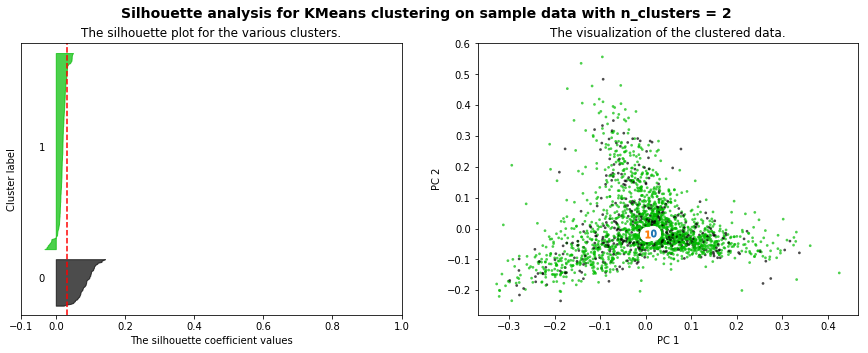

For n_clusters = 2, The average silhouette_score is : 0.032


In [91]:
X = exampleTFVects.toarray()
plotSilhouette(2, X)

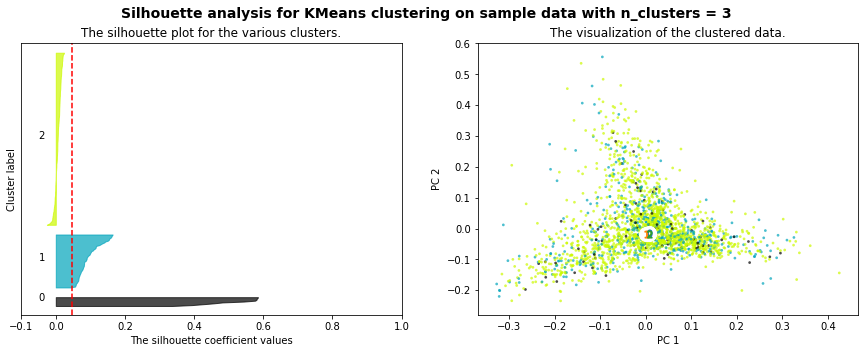

For n_clusters = 3, The average silhouette_score is : 0.046


In [92]:
plotSilhouette(3, X)

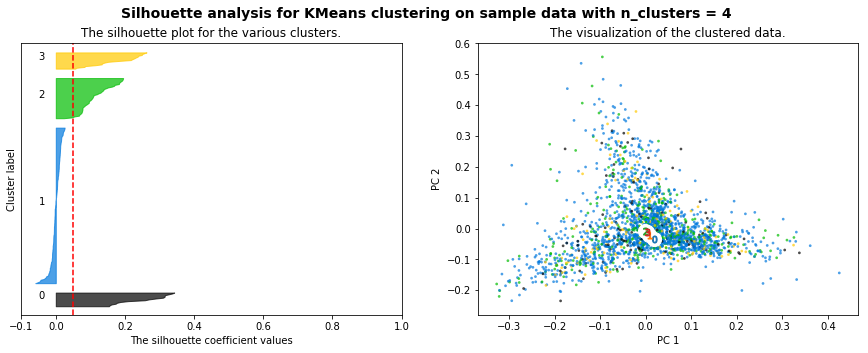

For n_clusters = 4, The average silhouette_score is : 0.049


In [93]:
plotSilhouette(4, X)

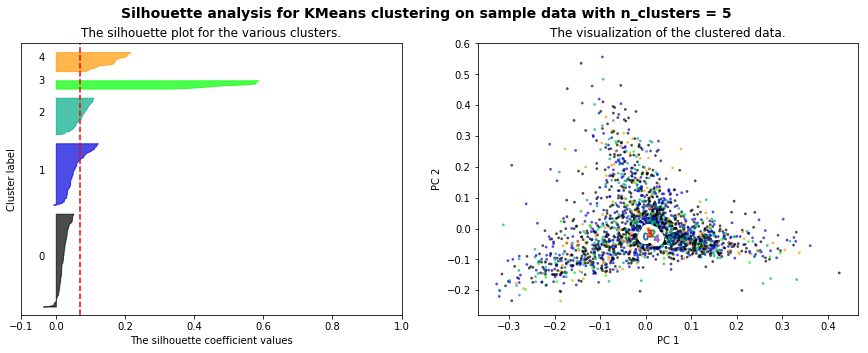

For n_clusters = 5, The average silhouette_score is : 0.071


In [94]:
plotSilhouette(5, X)

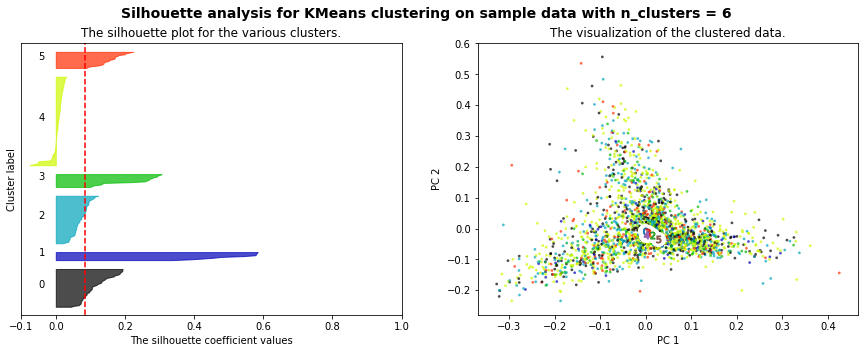

For n_clusters = 6, The average silhouette_score is : 0.086


In [95]:
plotSilhouette(6, X)

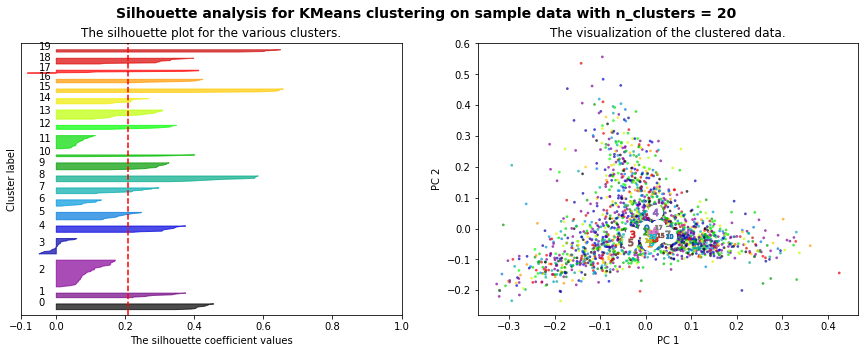

For n_clusters = 20, The average silhouette_score is : 0.209


In [96]:
plotSilhouette(20, X)

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [120]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [121]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [122]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\scipy\sparse\compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [123]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [124]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [125]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[126.        , 193.        ,   0.        ,   2.        ],
       [195.        , 200.        ,   0.        ,   3.        ],
       [198.        , 201.        ,   0.        ,   4.        ],
       [ 55.        , 202.        ,   0.37033177,   5.        ],
       [104.        , 169.        ,   0.40914841,   2.        ],
       [ 60.        ,  94.        ,   0.44134524,   2.        ],
       [ 99.        , 162.        ,   0.45096656,   2.        ],
       [151.        , 204.        ,   0.4553535 ,   3.        ],
       [117.        , 206.        ,   0.4650683 ,   3.        ],
       [ 52.        ,  96.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

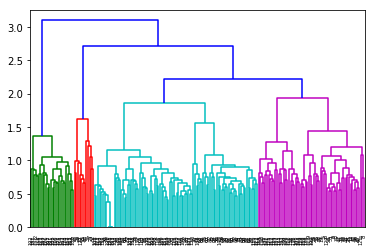

In [126]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

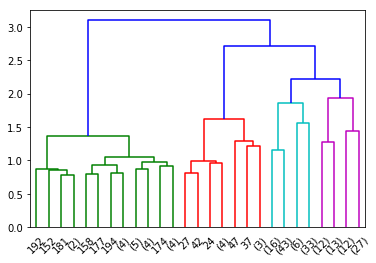

In [127]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [128]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4,
       3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4,
       4, 4, 4, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 1, 1,
       1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [129]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [130]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,category,source_file,text,kmeans_predictions,wald_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",0,4
1,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,Does anyone know how to reach Micron? I am in...,0,4
2,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,Hi there!\n\nCould some kind soul tell me what...,0,4
3,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,"""auto\nfrom",0,4
4,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\n Don't believe the hype. There is no su...,0,4
5,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,0,4
6,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,0,4
7,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",0,4
8,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,0,3
9,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,\n\n\nThe previous article referred to the fac...,0,4


# Now let's do it with our new data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [131]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\scipy\sparse\compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

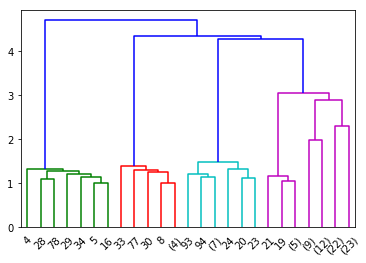

In [132]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [133]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


As we only used one senator for this there isn't any point in looking at the metrics, but you should if possible

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

The structure below reveals that there are broad similarities among documents in my corpora.

In [111]:
targetDF = df
textColumn = 'text'
numCategories = 3

In [117]:
df

,company,text,year,kmeans_predictions
0,3M Letter,dear shareholder:\n\nthanks to the hard work o...,2000,1
1,Alcoa Letter,luluâ\nmumÂ» nl am.â\n\n \n\n \n\n1â0 ai...,2000,1
2,American Express Letter,"cardmembers, a reflection of our successful ef...",2000,0
3,AT&T Letter,the transformation of at&t\n\nthree years ago ...,2000,1
4,Boeing Letter,here is our plan for growing the boeing compan...,2000,1
5,Caterpillar Letter,âplan. are in place to acmieve $30 illllon\n...,2000,1
6,Citigroup Letter,citigroup is\n\n230\n\n> > > > > > > > > dear ...,2000,0
7,Coca Cola Letter,"dear fellow share own ers,\n\nthe coca-cola co...",2000,1
8,Disney 2000 Le,i) e mxtl\n:: [h [u\n\n \n\nt0 felluh dissey ...,2000,1
9,DuPont Letter,"dupont in 2000 had a strong year, but by no me...",2000,1


In [112]:
letterTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
letterTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

In [113]:
letterTFVects[:100].todense()

matrix([[0.        , 0.03472166, 0.04089709, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.04053322, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.18018067, 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [115]:
letterCoocMat = letterTFVects * letterTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
letterCoocMat.setdiag(0)
letterlinkage_matrix = scipy.cluster.hierarchy.ward(letterCoocMat[:100, :100].toarray())

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


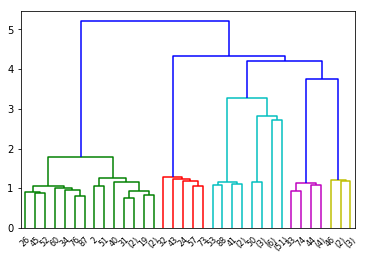

In [116]:
ax = scipy.cluster.hierarchy.dendrogram(letterlinkage_matrix, p=5, truncate_mode='level')

In [118]:
letter_linkage_matrix_full = scipy.cluster.hierarchy.ward(letterCoocMat.toarray())
letter_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(letter_linkage_matrix_full, 4, 'maxclust')


c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


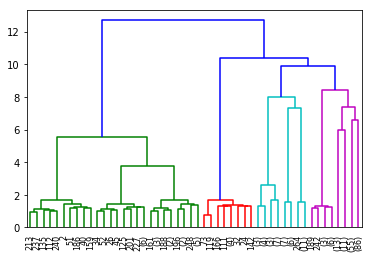

In [119]:
ax = scipy.cluster.hierarchy.dendrogram(letter_linkage_matrix_full, p=5, truncate_mode='level')

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [35]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, contact, meli..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, washington, c..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, surpris, amer..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immedi, releas, washington, c, today, senat, ..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immedi, releas, veteran, day, america, stand,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, mr, chairman,..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immedi, releas, washington, c, senat, edward,..."


In [40]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [41]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [42]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [43]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [44]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [45]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(1, 0.97007453)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [46]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [47]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(4, 0.9570967)]",0.000000,0.000000,0.000000,0.000000,0.957097,0.000000,0.000000,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(2, 0.28565612), (5, 0.70754147)]",0.000000,0.000000,0.285656,0.000000,0.000000,0.707541,0.000000,0.000000,0.000000,0.000000
201,04May2006Kennedy8.txt,"[(0, 0.0469556), (7, 0.9503892)]",0.046956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950389,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(3, 0.05174814), (5, 0.94593424)]",0.000000,0.000000,0.000000,0.051748,0.000000,0.945934,0.000000,0.000000,0.000000,0.000000
401,08Feb2005Kennedy0.txt,"[(7, 0.9894053)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.989405,0.000000,0.000000
501,09Nov2005Kennedy11.txt,"[(1, 0.9403191)]",0.000000,0.940319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(1, 0.9601344)]",0.000000,0.960134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(0, 0.39991808), (7, 0.3838356), (9, 0.213074...",0.399918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.383836,0.000000,0.213074
801,15Dec2005Kennedy5.txt,"[(8, 0.99785376)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.997854,0.000000
901,16May2007Kennedy5.txt,"[(1, 0.32023743), (6, 0.6427518)]",0.000000,0.320237,0.000000,0.000000,0.000000,0.000000,0.642752,0.000000,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [48]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.970075,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.0,0.000000,0.957097,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.991433,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.345374,0.000000,0.0,0.020816,0.000000,0.000000,0.264974,0.000000,0.277106,0.087003
4,0.000000,0.000000,0.0,0.996890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.0,0.990855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.981765,0.000000,0.000000
7,0.000000,0.000000,0.0,0.000000,0.000000,0.651737,0.000000,0.000000,0.315486,0.000000
8,0.000000,0.061787,0.0,0.000000,0.000000,0.433450,0.028070,0.000000,0.000000,0.473411
9,0.000000,0.135912,0.0,0.000000,0.000000,0.000000,0.834715,0.000000,0.000000,0.000000


First we can visualize as a stacked bar chart:

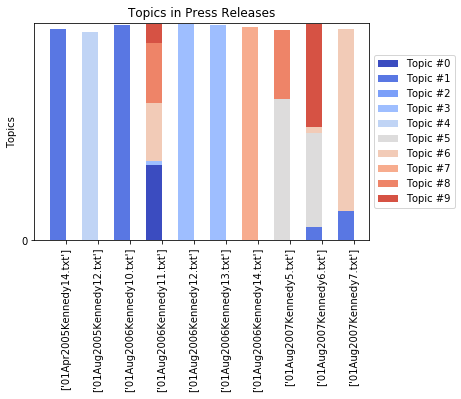

In [49]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

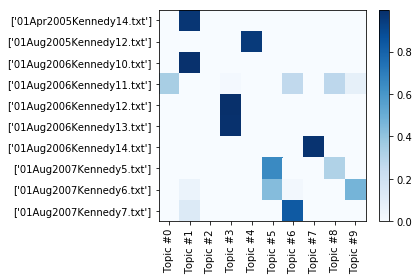

In [50]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [51]:
senlda.show_topic(1)

[('worker', 0.018812865),
 ('loan', 0.01052981),
 ('pension', 0.010499681),
 ('wagon', 0.008479556),
 ('import', 0.008461308),
 ('unit', 0.007463339),
 ('govern', 0.007241176),
 ('fund', 0.0069410265),
 ('employ', 0.0063477447),
 ('rate', 0.0059869867)]

And if we want to make a dataFrame:

In [52]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fda,worker,troop,wage,fund,govern,loan,fund,fund,mental
1,patient,loan,worker,minimum,worker,fund,depart,depart,worker,loan
2,inform,pension,fund,worker,unit,iraqi,inform,worker,loan,fund
3,review,wagon,pension,head,troop,depart,import,wagon,lender,lender
4,import,import,import,amend,wagon,author,wagon,import,victim,wagon
5,wagon,unit,govern,hour,loan,wagon,fund,cell,train,import
6,wind,govern,rule,govern,teacher,worker,worker,stem,wagon,treatment
7,project,fund,employ,wagon,import,unit,employ,river,employ,standard
8,product,employ,depart,fail,al,import,author,author,depart,head
9,senior,rate,author,troop,inform,commit,govern,global,medicaid,ill


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

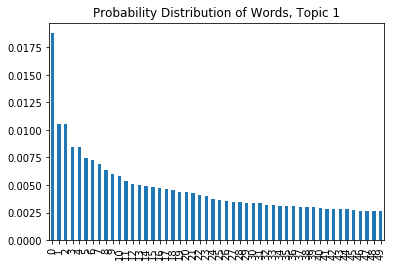

In [53]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [54]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

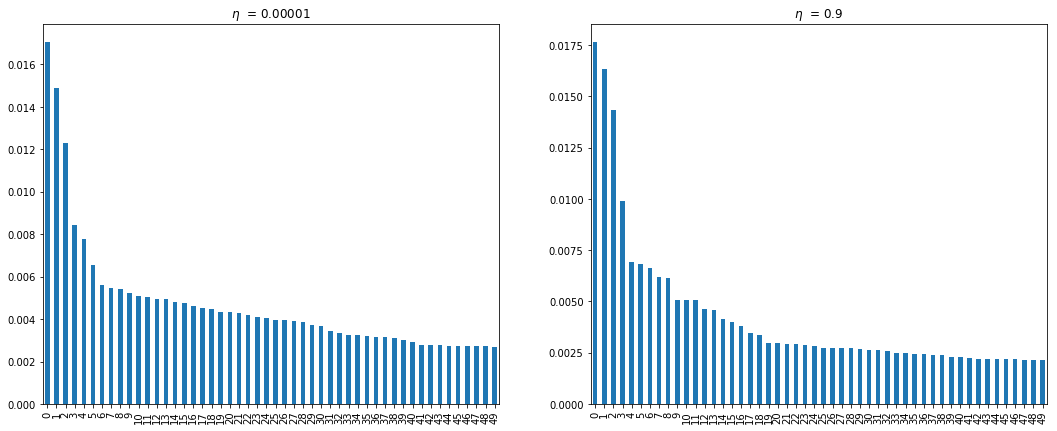

In [55]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [57]:
df = pandas.read_pickle('C:\\Users\\Andrew\\content-analysis-2018\\3-Clustering-and-Topic-Modeling\\pandasDF.pkl')

In [58]:
#Apply our functions
df['tokenized_text'] = df['text'].apply(lambda x: nltk.word_tokenize(x))
df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
df[::100]

,company,text,year,tokenized_text,normalized_tokens
0,3M Letter,dear shareholder:\n\nthanks to the hard work o...,2000,"[dear, shareholder, :, thanks, to, the, hard, ...","[dear, sharehold, thank, hard, work, ofthouszm..."
100,Johnson and Johnson Letter,chairmanâs letter\n\nto our\nshareholders\n\...,2010,"[chairmanâs, letter, to, our, shareholders, ...","[letter, sharehold, rememb, aycar, compani, se..."
200,Johnson and Johnson,I am often asked what led me to work in healt...,2014,"[I, am, often, asked, what, led, me, to, work,...","[often, ask, led, work, health, care, whi, cho..."


In [60]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

df['reduced_tokens'] = df['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [61]:
dictionary = gensim.corpora.Dictionary(df['reduced_tokens'])

In [62]:
corpus = [dictionary.doc2bow(text) for text in df['reduced_tokens']]

In [63]:
gensim.corpora.MmCorpus.serialize('letter.mm', corpus)
letmm = gensim.corpora.MmCorpus('letter.mm')

In [64]:
letterlda = gensim.models.ldamodel.LdaModel(corpus=letmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [65]:
letter1Bow = dictionary.doc2bow(df['reduced_tokens'][0])
letter1lda = letterlda[letter1Bow]
print("The topics of the company: {}".format(df['company'][0])+ 'in year: {}'.format(df['year'][0]))
print("are: {}".format(letter1lda))

The topics of the company: 3M Letter in year: 2000
are: [(4, 0.7282959), (5, 0.2658051)]


In [66]:
letterldaDF = pandas.DataFrame({
        'company' : df['company'],
        'topics' : [letterlda[dictionary.doc2bow(l)] for l in df['reduced_tokens']]
    })

In [67]:
#Dict to temporally hold the probabilities
lettertopicsProbDict = {i : [0] * len(letterldaDF) for i in range(letterlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(letterldaDF['topics']):
    for topicNum, prob in topicTuples:
        lettertopicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(letterlda.num_topics):
    letterldaDF['topic_{}'.format(topicNum)] = lettertopicsProbDict[topicNum]

letterldaDF[1::100]

,company,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,Alcoa Letter,"[(1, 0.97704226)]",0.0,0.977042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
101,JP Morgan and Chase Letter,"[(2, 0.9672563), (9, 0.026600206)]",0.0,0.000000,0.967256,0.0,0.0,0.0,0.0,0.0,0.0,0.026600
201,JPMorgan Chase,"[(2, 0.9866926), (9, 0.011965705)]",0.0,0.000000,0.986693,0.0,0.0,0.0,0.0,0.0,0.0,0.011966


In [68]:
letterldaDFV = letterldaDF[:10][['topic_%d' %x for x in range(10)]]
letterldaDFVisN = letterldaDF[:10][['company']]
letterldaDFVis = letterldaDFV.as_matrix(columns=None)
letterldaDFVisNames = letterldaDFVisN.as_matrix(columns=None)
letterldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.000000,0.000000,0.0,0.727560,0.266541,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.977042,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.626406,0.000000,0.000000,0.0,0.000000,0.000000,0.362066,0.000000,0.000000,0.000000
3,0.337411,0.000000,0.000000,0.0,0.000000,0.000000,0.167957,0.348433,0.141823,0.000000
4,0.000000,0.000000,0.000000,0.0,0.868146,0.000000,0.121530,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.0,0.986053,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.024577,0.527073,0.0,0.163393,0.132785,0.000000,0.000000,0.148337,0.000000
7,0.000000,0.000000,0.000000,0.0,0.971253,0.000000,0.000000,0.000000,0.020071,0.000000
8,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.995042,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.0,0.000000,0.019556,0.000000,0.000000,0.000000,0.968736


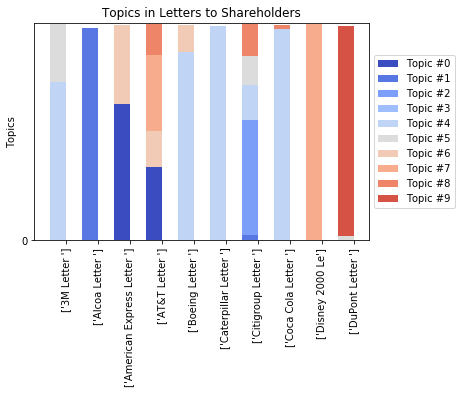

In [70]:
N = 10
ind = np.arange(N)
K = letterlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, letterldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, letterldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += letterldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Letters to Shareholders')
plt.xticks(ind+width/2, letterldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

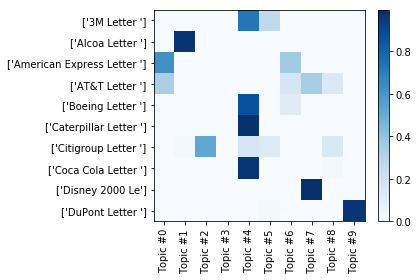

In [71]:
plt.pcolor(letterldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(letterldaDFVis.shape[0])+0.5, letterldaDFVisNames);
plt.xticks(np.arange(letterldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [72]:
letterlda.show_topic(1)

[('product', 0.022458361),
 ('invest', 0.021859108),
 ('market', 0.019213535),
 ('share', 0.012616378),
 ('bank', 0.011530022),
 ('client', 0.0113322325),
 ('growth', 0.01092605),
 ('perform', 0.010677682),
 ('return', 0.009289284),
 ('grow', 0.0088504935)]

In [73]:
topicsDict = {}
for topicNum in range(letterlda.num_topics):
    topicWords = [w for w, p in letterlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

letterwordRanksDF = pandas.DataFrame(topicsDict)
letterwordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,growth,product,bank,product,growth,product,product,product,market,growth
1,market,invest,market,growth,market,market,invest,market,invest,market
2,global,market,growth,ge,product,growth,market,invest,global,product
3,bank,share,product,bank,invest,invest,growth,growth,product,bank
4,product,bank,global,market,bank,global,network,bank,growth,invest
5,invest,client,client,global,share,client,card,ge,client,return
6,share,growth,grow,invest,global,bank,bank,sale,share,share
7,client,perform,invest,grow,return,share,share,global,bank,global
8,data,return,share,share,perform,grow,global,grow,ibm,client
9,import,grow,perform,perform,import,perform,return,import,grow,earn


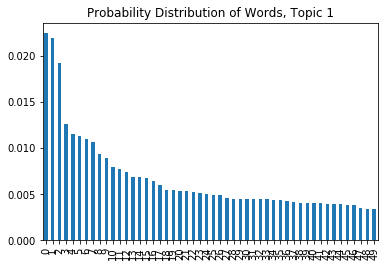

In [74]:
lettertopic1_df = pandas.DataFrame(letterlda.show_topic(1, topn=50))
plt.figure()
lettertopic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [76]:
letterlda1 = gensim.models.ldamodel.LdaModel(corpus=letmm, id2word=dictionary, num_topics=10, eta = 0.00001)
letterlda2 = gensim.models.ldamodel.LdaModel(corpus=letmm, id2word=dictionary, num_topics=10, eta = 0.9)

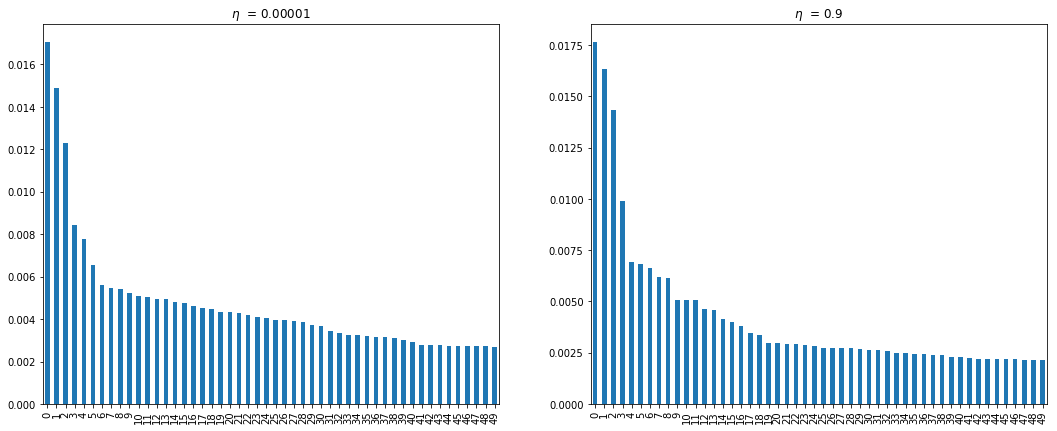

In [77]:
lettertopic11_df = pandas.DataFrame(letterlda1.show_topic(1, topn=50))
lettertopic21_df = pandas.DataFrame(letterlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

In [78]:
topicsDict = {}
for topicNum in range(letterlda.num_topics):
    topicWords = [w for w, p in letterlda2.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

letterwordRanksDF = pandas.DataFrame(topicsDict)
letterwordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,market,growth,product,growth,bank,market,market,growth,product,growth
1,product,product,growth,invest,client,product,product,market,growth,market
2,bank,invest,market,market,invest,invest,invest,product,market,invest
3,growth,bank,invest,share,market,growth,bank,bank,invest,client
4,global,global,global,global,product,ge,global,invest,sale,global
5,invest,market,import,bank,growth,bank,growth,ge,global,product
6,client,client,share,product,global,share,ge,global,share,bank
7,grow,share,bank,digit,asset,cash,share,grow,bank,share
8,share,return,perform,grow,return,global,import,return,perform,earn
9,network,annual,return,ge,share,grow,grow,annual,grow,data


This structure reveals that annual letters to shareholders are very similar across documents. Even within topic groupings, markets, growth, and investing are fairly common. However, the structure also shows that documents can vary in subsections: topics separately contain networks/clients, global, bank, data.